# Production Planning Optimisation at a High Tech Manufacturing Firm

In [1]:
#Relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pulp
import os
import datetime as dt
import csv
from itertools import chain
pd.options.mode.chained_assignment = None

## Input

Reading files. 

In [2]:
#Setting correct workspace
os.chdir('Input Data')

#Defining function to read csv files and unnest them
def read_to_list(csv_file):
    """
    Reads the csv file and converts the content to an unnested list. 
    """
    df = pd.read_csv(csv_file).values.tolist()
    
    return list(chain.from_iterable(df))

#Reading data and converting to lists
final_assemblies = read_to_list('final_assemblies.csv')
input_materials = read_to_list('input_materials.csv')

#Defining function to read csv files drop first column
def read_to_dict(csv_file):
    """
    Reads the csv file and converts the content to a dictionary. 
    """    
    df = pd.read_csv(csv_file)
    df.set_index('Unnamed: 0', inplace=True, drop=True)
    
    return df

#Reading data and converting to dicts
material_requirements_matrix = read_to_dict('material_requirements.csv').T.to_dict()
supply_input_materials = read_to_dict('supply_input_materials.csv').T.to_dict()
inventory_onhand = dict(zip(read_to_dict('inventory_onhand.csv').columns, 
                            read_to_dict('inventory_onhand.csv').values[0]))

Defining remaining parameters.

In [3]:
#Setting time window
time = range(30)

#Bottleneck rate
bottleneck_rate = 2

#Revenue vector
revenue = dict(zip(time,[1/(1+t) for t in time]))

#Maximum number of tubes per final assembly
dict_max_tubes = {'assembly 1': 10,'assembly 2': 12, 'assembly 3': 8, 'assembly 4': 10, 'assembly 5': 10}

## The Model

In [4]:
#Defining problem
prob = pulp.LpProblem('ILP_Acc_Tubes', pulp.LpMaximize)

#Decision variable
X = pulp.LpVariable.dicts('X', (time, final_assemblies), lowBound=0, cat=pulp.LpInteger)
I = pulp.LpVariable.dicts('I', (time, input_materials), lowBound=0, cat=pulp.LpInteger)
D = pulp.LpVariable.dicts('D', (time, input_materials), lowBound=0, cat=pulp.LpInteger)

#Objective function
prob += (pulp.lpSum([revenue[t]*X[t][a] for t in time for a in final_assemblies]), 'Sum_Rev_Production')

#Constraints
for dynode in input_materials: #constraint 1
    for t in time[1::]:
        prob += (I[t][dynode] == I[t-1][dynode] + supply_input_materials[t-1][dynode] - D[t-1][dynode], 'Inv_Balancing_Eq_{}_{}'.format(dynode, t))        

for dynode in input_materials: #constraint 2
    for t in time:
        prob += (D[t][dynode] == pulp.lpSum([material_requirements_matrix[a][dynode]*X[t][a] for a in final_assemblies]), 'Total_Demand_{}_week_{}'.format(dynode, t))

for dynode in input_materials: #constraint 3
    prob += (I[0][dynode] == inventory_onhand[dynode], 'Initial_Inv_{}'.format(dynode))       
        
for a in dict_max_tubes: #constraint 4
     prob += ((pulp.lpSum([X[t][a] for t in time]) <= dict_max_tubes[a], 'Max_Tubes_of_a_Type_{}'.format(a)))

for t in time: #constraint 5
    prob += (pulp.lpSum([X[t][a] for a in final_assemblies]) <= bottleneck_rate, 'Bottleneck_Rate_Week_{}'.format(t))        
                
for dynode in input_materials: #constraint 6
    for t in time[1::]:
        prob += (D[t][dynode] <= I[t][dynode], 'Inv_Demand_{}_{}'.format(dynode, t))    

## Results

In [5]:
#The problem is solved using PuLP's choice of Solver with a stated Performance Gap and Maximum Time Limit
prob.solve(pulp.COIN_CMD(gapRel = 0.1, timeLimit=60))

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - cbc /var/folders/hq/n61qpt4d58n7fxmnth4nc_c80000gn/T/20efa691c9dc4549a1e73961bdc2b2fe-pulp.mps max sec 60 ratio 0.1 timeMode elapsed branch printingOptions all solution /var/folders/hq/n61qpt4d58n7fxmnth4nc_c80000gn/T/20efa691c9dc4549a1e73961bdc2b2fe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1998 COLUMNS
At line 10761 RHS
At line 12755 BOUNDS
At line 14226 ENDATA
Problem MODEL has 1993 rows, 1470 columns and 5672 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 60
ratioGap was changed from 0 to 0.1
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.52874 - 0.03 seconds
Cgl0003I 0 fixed, 16 tightened bounds, 57 strengthened rows, 5 substitutions
Cgl0003I 0 fixed, 2 tightened bounds, 56 strengthened rows, 5 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 55 strengthened rows, 5 substitutions
Cgl00

0

In [6]:
#The status of the solution is printed to the screen
print("Status:", pulp.LpStatus[prob.status])

Status: Not Solved


In [7]:
#Defining function that retrieves solved production quantities
def production_quantities(prob, time):
    """
    Returns a dataframe containing the production quantities for each final assembly for each week.
    """
    r = pd.DataFrame(index=time)

    for v in prob.variables():
        if v.varValue > 0:
            if v.name[0] == 'X':
                week = int(v.name.split('_')[1])
                if len(v.name.split('_')[-1]) == 1:
                    assembly = 'assembly_0{}'.format(v.name.split('_')[-1])
                else:
                    assembly = 'assembly_{}'.format(v.name.split('_')[-1])
                r.loc[week,assembly] = v.varValue
    r.fillna(0, inplace=True)
    r.sort_index(axis=1, inplace=True)
    r.sort_index(axis=0, inplace=True)
    
    return r

In [8]:
#Executing function production quantities
production_quantities = production_quantities(prob, time)

In [9]:
#Showing result function produciton quantities
production_quantities

,assembly_01,assembly_02,assembly_03,assembly_04,assembly_05
0,0.011292,0.000000,0.473684,0.500000,0.296651
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.208333,0.217391
3,0.397301,0.000000,0.174401,0.209566,0.002446
4,0.081023,0.034672,0.193902,0.093430,0.035706
5,0.100000,0.187500,0.000000,0.000000,0.000000
6,0.275000,0.241071,0.062500,0.000000,0.068051
7,0.250000,0.095238,0.041667,0.000000,0.061708
8,0.099287,0.201708,0.042261,0.073506,0.046589
9,0.000000,0.134199,0.083333,0.090909,0.120425


In [10]:
#Defining function that retrieves the solved inventory quantities
def inventory_quantities(prob, time):
    """
    Returns a dataframe containing the inventory levels  
    for each final assembly for each week.
    """
    r = pd.DataFrame(index=time)

    for v in prob.variables():
        if v.varValue > 0:
            if v.name[0] == 'I':
                week = int(v.name.split('_')[1])
                if len(v.name.split('_')[-1]) == 1:
                    assembly = 'material 0{}'.format(v.name.split('_')[-1])
                else:
                    assembly = 'material {}'.format(v.name.split('_')[-1])
                r.loc[week,assembly] = v.varValue
    r.fillna(0, inplace=True)
    r.sort_index(axis=0, inplace=True)
    r.sort_index(axis=1, inplace=True)
    
    return r

In [11]:
#Executing function inventory quantities
inventory_quantities = inventory_quantities(prob, time)

In [12]:
#Showing results inventory quantities
inventory_quantities

,material 01,material 02,material 03,material 04,material 05,material 06,material 07,material 08,material 09,material 10,...,material 13,material 14,material 15,material 16,material 17,material 18,material 19,material 20,material 21,material 22
0,18.000000,14.000000,10.000000,10.000000,15.000000,17.000000,15.000000,16.000000,16.000000,18.000000,...,12.000000,13.000000,13.000000,10.000000,12.0,15.000000,12.000000,12.000000,18.000000,18.000000
1,14.620670,4.405742,11.000000,0.000000,13.240383,10.061244,14.287081,9.213971,2.473684,22.819330,...,5.500000,7.000000,6.947368,0.000000,12.0,3.380383,0.000000,4.363636,13.363636,15.066986
2,23.620670,9.405742,12.000000,5.000000,18.240383,13.061244,22.287081,20.213971,13.473684,27.819330,...,11.500000,8.000000,9.947368,5.000000,12.0,9.380383,6.000000,10.363636,16.363636,16.066986
3,27.403279,15.405742,14.000000,14.000000,23.240383,13.409070,22.634907,18.681363,12.107742,32.819330,...,13.958333,5.250000,12.947368,6.000000,12.0,3.621325,6.666667,11.899868,13.233202,13.719160
4,22.206653,6.274107,15.000000,8.000000,21.093158,7.085839,29.571306,11.717448,9.129865,31.462519,...,16.395717,2.477818,11.982554,2.970424,12.0,3.000000,8.000000,13.500340,14.186724,15.670236
5,24.619379,2.000000,17.271885,11.000000,21.862227,8.852887,34.741475,14.762559,12.772614,34.542053,...,18.905939,3.796086,9.686220,5.000000,12.0,3.000000,10.058202,13.529594,15.508310,17.956116
6,23.631879,7.000000,14.334385,14.750000,20.762227,9.852887,37.866475,16.087559,19.272614,33.567053,...,19.030939,5.796087,11.686220,5.062500,12.0,9.000000,8.933202,16.217094,17.508310,18.956116
7,14.646877,6.000000,10.271885,14.050906,13.576513,7.396069,33.829300,15.926158,17.802285,27.827767,...,17.763082,6.796087,13.623720,2.000000,12.0,8.509641,5.442130,13.379489,19.215348,18.595103
8,15.034938,3.000000,11.271885,14.518532,12.624132,4.000000,35.748708,15.104301,19.367333,25.113481,...,18.286891,9.796086,13.915386,6.000000,12.0,10.504845,7.555225,17.016565,20.042900,19.360947
9,17.590521,2.000000,10.036019,18.958662,13.518378,5.000000,33.292996,11.841917,24.081306,22.894155,...,14.792891,10.472986,15.196946,5.000000,12.0,11.909795,7.138599,15.316008,22.157715,19.429173


In [13]:
#Defining function that retrieves solved demanded quantities
def demand_quantities(prob, time):
    """
    Returns a dataframe containing the production quantities for each final assembly for each week.
    """
    r = pd.DataFrame(index=time)

    for v in prob.variables():
        if v.varValue > 0:
            if v.name[0] == 'D':
                week = int(v.name.split('_')[1])
                if len(v.name.split('_')[-1]) == 1:
                    assembly = 'material_0{}'.format(v.name.split('_')[-1])
                else:
                    assembly = 'material_{}'.format(v.name.split('_')[-1])
                r.loc[week,assembly] = v.varValue
    r.fillna(0, inplace=True)
    r.sort_index(axis=1, inplace=True)
    r.sort_index(axis=0, inplace=True)
    
    return r

In [14]:
#Executing function demand quantities
demand_quantities = demand_quantities(prob, time)

In [15]:
#Showing results demand quantities
demand_quantities

,material_01,material_02,material_03,material_04,material_05,material_06,material_07,material_08,material_09,material_10,...,material_12,material_13,material_14,material_15,material_16,material_18,material_19,material_20,material_21,material_22
0,7.379330,11.594258,0.000000,18.000000,7.759617,16.938756,7.712919,15.786029,26.526316,0.180670,...,11.271005,8.500000,9.000000,8.052632,12.000000,15.619617,17.000000,13.636364,5.636364,5.933014
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5.217391,0.000000,0.000000,5.000000,0.000000,5.652174,5.652174,8.532609,9.365942,0.000000,...,4.583333,3.541667,3.750000,0.000000,5.000000,8.759058,3.333333,7.463768,4.130435,4.347826
3,9.196625,12.131635,0.000000,14.000000,9.147225,11.323232,0.063601,12.963915,7.977877,6.356812,...,14.145662,3.562616,3.772182,2.964814,5.029576,3.621325,6.666667,3.399528,0.046478,0.048924
4,3.587275,6.274107,0.728115,8.000000,5.230931,6.232952,1.829832,4.954889,7.357251,1.920466,...,4.000000,2.489778,1.681732,3.296334,2.970424,3.000000,5.941798,2.970746,0.678414,0.714119
5,6.987500,2.000000,3.937500,6.250000,6.100000,2.000000,4.875000,5.675000,4.500000,4.975000,...,2.400000,4.875000,0.000000,0.000000,3.937500,3.000000,4.125000,4.312500,0.000000,0.000000
6,13.985002,7.000000,5.062500,14.699094,11.185714,8.456817,8.037175,12.161400,8.470329,8.739286,...,6.600000,6.267857,0.000000,1.062500,5.062500,5.490359,6.491071,6.837606,1.292963,1.361013
7,9.611939,6.000000,2.000000,10.532374,6.952381,7.396069,4.080593,8.821857,4.434952,5.714286,...,6.000000,2.476190,0.000000,0.708333,2.000000,3.004796,2.886905,3.362924,1.172448,1.234156
8,8.444416,3.000000,4.235866,8.559869,7.105753,4.000000,6.455711,8.262384,8.286027,5.219327,...,4.000000,6.494000,1.323101,0.718441,6.000000,5.595050,6.416626,6.700556,0.885185,0.931774
9,6.245179,2.000000,2.818182,7.370425,4.554113,4.714384,6.620228,6.701299,9.453463,2.415584,...,2.000000,5.034632,1.636364,1.416667,5.000000,6.582841,5.990260,6.829201,2.288076,2.408501


## Plots

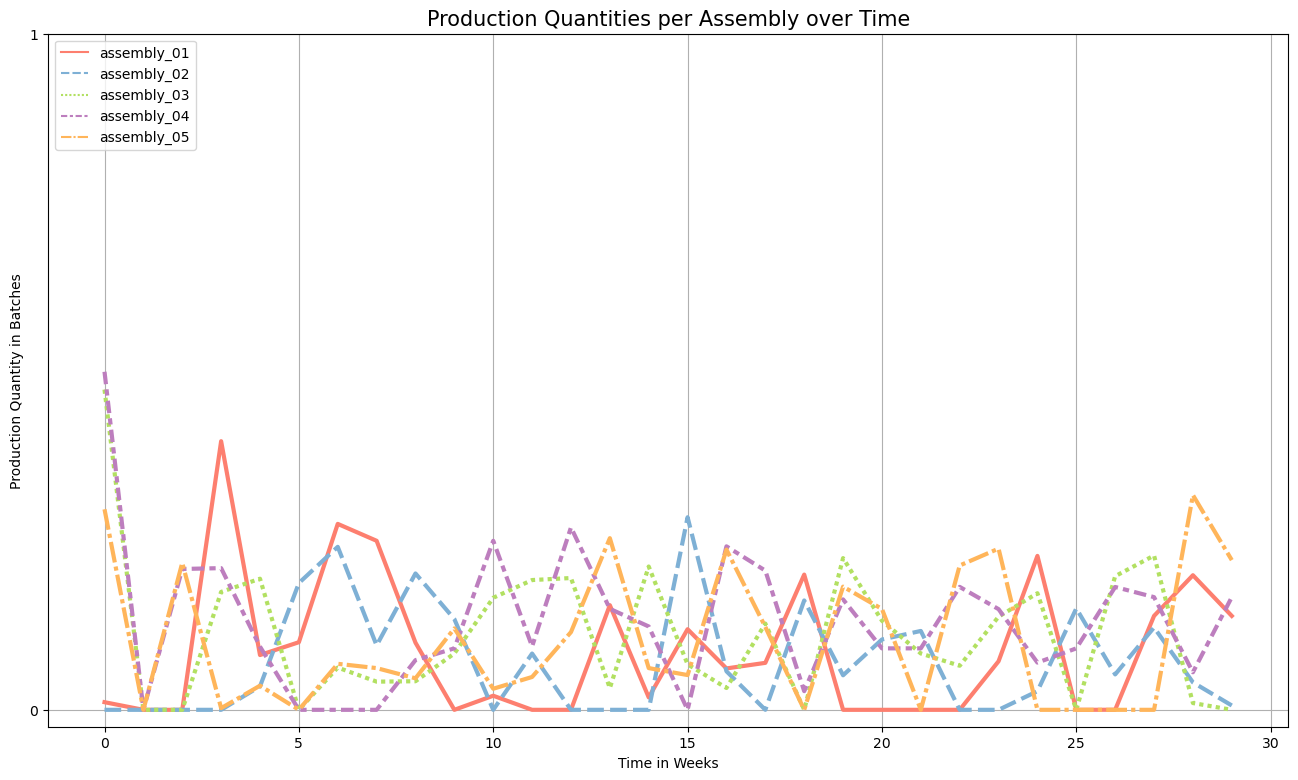

In [16]:
#Plotting solved production variable over time
palette = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a"]
y_ticks = list(np.arange(0, 2, 1))
x_ticks = list(np.arange(0, 35, 5))

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(ax=ax, data=production_quantities, palette=palette, linewidth=3)
ax.legend(loc='upper left')
ax.set_title('Production Quantities per Assembly over Time', size=15)
ax.set_xlabel('Time in Weeks')
ax.set_ylabel('Production Quantity in Batches')
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.grid(which='major')

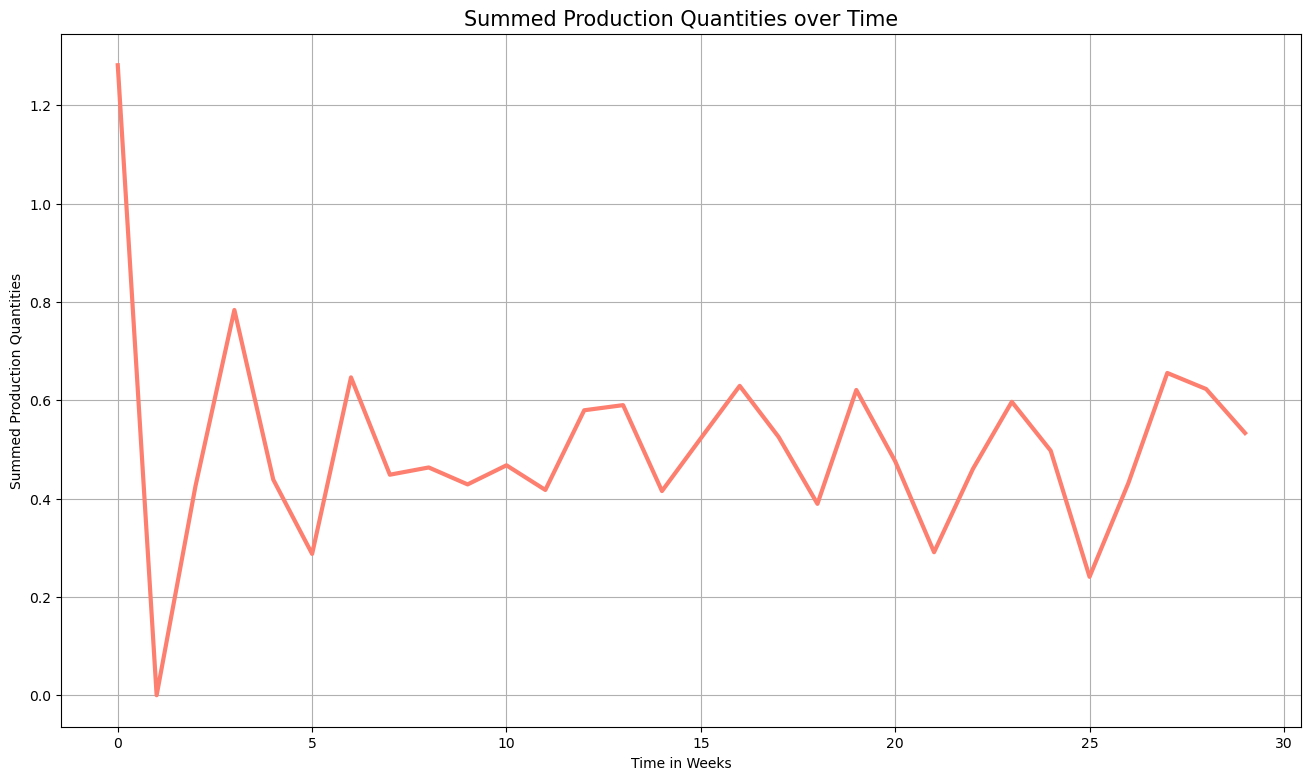

In [17]:
#Plotting summed production quantities over time
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(ax=ax, data=production_quantities.sum(axis=1), color="#fd7f6f", linewidth=3)
ax.set_title('Summed Production Quantities over Time', size=15)
ax.set_xlabel('Time in Weeks')
ax.set_ylabel('Summed Production Quantities')
ax.grid()

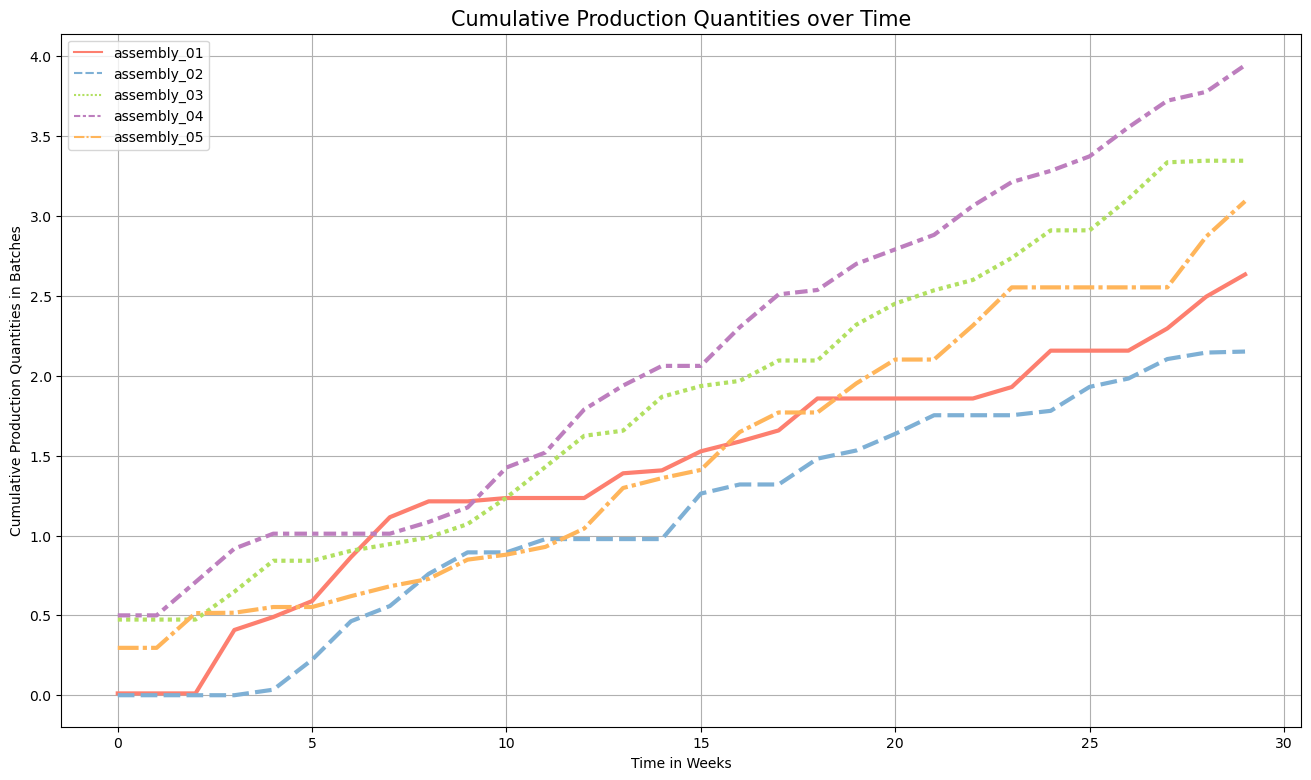

In [18]:
#Plotting solved cumulative production variable over time
palette = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a"]

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(ax=ax, data=production_quantities.cumsum(), palette=palette, linewidth=3)
ax.legend(loc='upper left')
ax.set_title('Cumulative Production Quantities over Time', size=15)
ax.set_xlabel('Time in Weeks')
ax.set_ylabel('Cumulative Production Quantities in Batches')
ax.grid()

This part probably requires some explanation. To prevent over clouding the plot with points and numbers I decided to place these points in a sparser manner. First, I want to denote the extreme points in the plot. So, points that are in between two points that have a lower value or a higher value. Second points are added when the distance to the previous point in two steps. This behaviour is captured by the ind-true_count condition. Last, the begin point and end point are added. At some points it still might look a bit clouded, but it is a huge improvement compared to annotating each point. 

In [19]:
def markers_on(df):
    """
    Returns a list containing the indices of the markers that will be used for annotations in the figure. 
    """
    true_count = 0
    list_markers_on = []
    for ind, value in enumerate(df):
        if (ind > 0) & (ind < df.shape[0]-1):
            if ((df[ind-1] <= value) and (df[ind+1] <= value)) or ((df[ind-1] >= value) and (df[ind+1] >= value)) or (ind-true_count > 1):
                list_markers_on.append(True)
                true_count = ind
            else:
                list_markers_on.append(False)
        else:
            list_markers_on.append(False)
        
    indices = list(set([0] + [ind for ind, value in enumerate(list_markers_on) if value == True ] + [29]))

    return indices

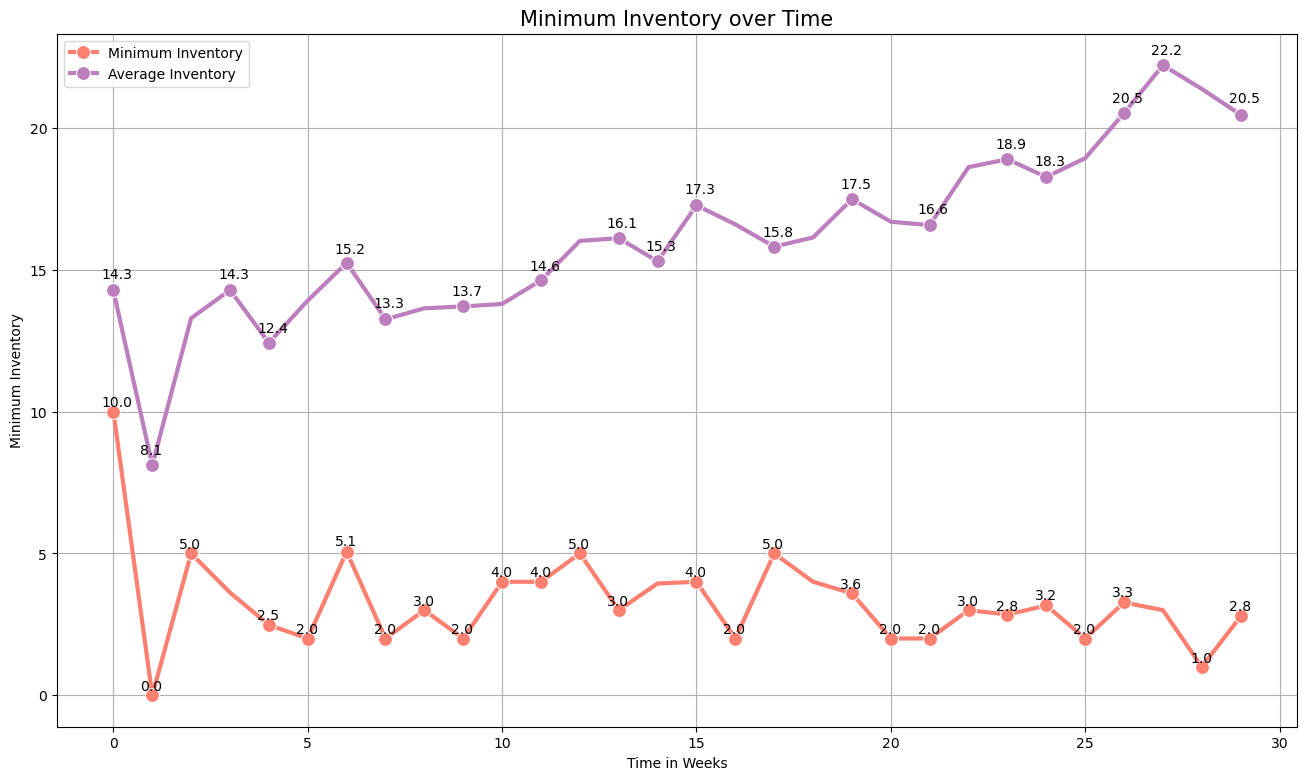

In [20]:
#Determining markers for annotation figure 
markers_min = markers_on(inventory_quantities.min(axis=1))
markers_avg = markers_on(inventory_quantities.mean(axis=1))

#Plotting solved inventory variable over time
fig, ax = plt.subplots(figsize=(16,9))

sns.lineplot(ax=ax, data=inventory_quantities.min(axis=1), color="#fd7f6f", label='Minimum Inventory', linewidth=3, 
markevery=markers_on(inventory_quantities.min(axis=1)), marker='o', markersize=10)
for x_marker in markers_min:
    y_marker = round(inventory_quantities.min(axis=1)[x_marker], 1)
    ax.annotate(str(y_marker), (x_marker, y_marker), (x_marker - ax.get_xlim()[1]/100, y_marker + ax.get_ylim()[1]/60))

sns.lineplot(ax=ax, data=inventory_quantities.mean(axis=1), color="#bd7ebe", label='Average Inventory', linewidth=3, 
markevery=markers_on(inventory_quantities.mean(axis=1)), marker='o', markersize=10)
for x_marker in markers_avg:
    y_marker = round(inventory_quantities.mean(axis=1)[x_marker], 1)
    ax.annotate(str(y_marker), (x_marker, y_marker), (x_marker - ax.get_xlim()[1]/100, y_marker + ax.get_ylim()[1]/60))

ax.legend()
ax.set_title('Minimum Inventory over Time', size=15)
ax.set_xlabel('Time in Weeks')
ax.set_ylabel('Minimum Inventory')
ax.grid()
